# Parte 2

## Árboles de Decisión

### Exploración, Preprocesamiento y Transformación de Datos

#### Imports

In [84]:
import numpy as np 
import pandas as pd
import re 

import matplotlib.pyplot as plt
import seaborn as sns

import os

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import ToktokTokenizer
from nltk.stem import SnowballStemmer

!pip install eli5
import eli5

from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier, export_graphviz, plot_tree
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder

!pip install dtreeviz
from dtreeviz.trees import *

import graphviz

from string import punctuation

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import joblib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [14]:
months = {
            'January': 1,
            'February': 2,
            'March': 3,
            'April': 4,
            'May': 5,
            'June': 6,
            'July': 7,
            'August': 8,
            'September': 9, 
            'October': 10,
            'November': 11,
            'December': 12
         }

month_to_num = lambda m: months[m]

#### Importación del Dataframe

In [15]:
df = pd.read_csv('hotel_bookings.csv', encoding='latin-1')
bookings = df.copy()
bookings.T

,0,1,2,3,4,5,6,7,8,9,...,119380,119381,119382,119383,119384,119385,119386,119387,119388,119389
hotel,Resort Hotel,Resort Hotel,Resort Hotel,Resort Hotel,Resort Hotel,Resort Hotel,Resort Hotel,Resort Hotel,Resort Hotel,Resort Hotel,...,City Hotel,City Hotel,City Hotel,City Hotel,City Hotel,City Hotel,City Hotel,City Hotel,City Hotel,City Hotel
is_canceled,0,0,0,0,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
lead_time,342,737,7,13,14,14,0,9,85,75,...,44,188,135,164,21,23,102,34,109,205
arrival_date_year,2015,2015,2015,2015,2015,2015,2015,2015,2015,2015,...,2017,2017,2017,2017,2017,2017,2017,2017,2017,2017
arrival_date_month,July,July,July,July,July,July,July,July,July,July,...,August,August,August,August,August,August,August,August,August,August
arrival_date_week_number,27,27,27,27,27,27,27,27,27,27,...,35,35,35,35,35,35,35,35,35,35
arrival_date_day_of_month,1,1,1,1,1,1,1,1,1,1,...,31,31,30,31,30,30,31,31,31,29
stays_in_weekend_nights,0,0,0,0,0,0,0,0,0,0,...,1,2,2,2,2,2,2,2,2,2
stays_in_week_nights,0,0,1,1,2,2,2,2,3,3,...,3,3,4,4,5,5,5,5,5,7
adults,2,2,1,1,2,2,2,2,2,2,...,2,2,3,2,2,2,3,2,2,2


#### Descripción de los Datos

Prepararemos un dataframe donde cada índice, representa un feature del dataset y el mismo estará asociado a su data type correspondiente.

In [16]:
types = pd.DataFrame(bookings.dtypes).rename(columns = {0: 'Data Type'}, inplace=False)
types

,Data Type
hotel,object
is_canceled,int64
lead_time,int64
arrival_date_year,int64
arrival_date_month,object
arrival_date_week_number,int64
arrival_date_day_of_month,int64
stays_in_weekend_nights,int64
stays_in_week_nights,int64
adults,int64


Ahora debemos ver que datos de estos son categóricos y marcarlos.

In [17]:
invalid_values = {'', 'nan'}
discrete_features_list = ['hotel', 'is_canceled', 'meal', 'market_segment', 'customer_type',  
                          'distribution_channel', 'is_repeated_guest', 'reserved_room_type',
                          'deposit_type', 'reservation_status', 'assigned_room_type']
discrete_features = dict()

for f in discrete_features_list:
    discrete_features[f] = {i for i in set(bookings[f].unique()) if i not in invalid_values}

discrete_features

{'assigned_room_type': {'A',
  'B',
  'C',
  'D',
  'E',
  'F',
  'G',
  'H',
  'I',
  'K',
  'L',
  'P'},
 'customer_type': {'Contract', 'Group', 'Transient', 'Transient-Party'},
 'deposit_type': {'No Deposit', 'Non Refund', 'Refundable'},
 'distribution_channel': {'Corporate', 'Direct', 'GDS', 'TA/TO', 'Undefined'},
 'hotel': {'City Hotel', 'Resort Hotel'},
 'is_canceled': {0, 1},
 'is_repeated_guest': {0, 1},
 'market_segment': {'Aviation',
  'Complementary',
  'Corporate',
  'Direct',
  'Groups',
  'Offline TA/TO',
  'Online TA',
  'Undefined'},
 'meal': {'BB', 'FB', 'HB', 'SC', 'Undefined'},
 'reservation_status': {'Canceled', 'Check-Out', 'No-Show'},
 'reserved_room_type': {'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'L', 'P'}}

Y los actualizamos en el dataframe de tipos.

Y ahora tenemos una forma más simple de ver que representa cada feature; sabemos que si es categórica (es decir, presenta una cantidad discreta de valores), booleana (representado por un cero o un uno), numérica (enteros o de punto flotante) u ordinales (object types). Aclaramos que los "Undefined" representan casos donde ninguno de los otros valores representa la reserva en cuestión, es decir, sería mejor reemplazarlos por un "None".

In [18]:
bookings.hotel.unique()

array(['Resort Hotel', 'City Hotel'], dtype=object)

In [19]:
for f in discrete_features_list:
    types.at[f, 'Data Type'] = discrete_features[f]

types

,Data Type
hotel,"{Resort Hotel, City Hotel}"
is_canceled,"{0, 1}"
lead_time,int64
arrival_date_year,int64
arrival_date_month,object
arrival_date_week_number,int64
arrival_date_day_of_month,int64
stays_in_weekend_nights,int64
stays_in_week_nights,int64
adults,int64


A continuación indicamos que representa cada columna del dataframe:

- **hotel:** Tipo de hotel.
- **is_cancelled:** Indica si la reserva fue cancelada.
- **lead_time:** Días entre que se hace la reserva y la persona que reservó llega al hotel.
- **arrival_date_year:** Año de llegada.
- **arrival_date_month:** Mes de llegada.
- **arrival_date_week_number:** Nombre de la semana de llegada.
- **arrival_date_day_of_month:** Día del mes de llegada.
- **stays_in_weekend_nights:** Noches de fin de semana reservadas.
- **stays_in_week_nights:** Noches durante la semana reservadas.
- **adults:** Número de adultos.
- **children:** Número de niños.
- **babies:** Número de bebes.
- **meal:** Indica los platos cubiertos por el hotel.
- **country:** Código del país.
- **market_segment:** Forma de reserva.
- **distribution_channel:** Canal de distribución de la reserva.
- **is_repeated_guest:** Indica si la(s) persona(s) repite(n) la reserva.
- **previous_cancellations:** Cantidad de reservas canceladas por el mismo cliente en el pasado.
- **previous_bookings_not_canceled:** Cantidad de reservas no canceladas por el mismo cliente en el pasado.
- **reserved_room_type:** Código del tipo de habitación reservada.
- **assigned_room_type:** Número de habitación reservada.
- **booking_changes:** Número de cambios en la reserva.
- **deposit_type:** Forma en la que el cliente deposita el dinero de la reserva.
- **agent:** Código de la agencia que realizó la reserva.
- **company:** Companía que realizó la reserva.
- **days_in_waiting_list:** Días en la lista de espera.
- **customer_type:** Tipo de consumidor.
- **adr:** Beneficio total dividido entre la cantidad total de habitaciones disponibles.
- **required_car_parking_spaces:** Cantidad de lugares de estacionamiento pedidos por el cliente.
- **total_of_special_requests:** Cantidad de pedidos especiales por el cliente.
- **reservation_status:** Estado de la reserva.
- **reservation_status_date:** Fecha en el que se setteó por última vez el estado de la reserva.



Se pide ver también como aparecen las variables categóricas, por lo que vamos a ver los porcentajes de aparición de cada uno:

In [20]:
for f in discrete_features_list:
    print(f"\n{pd.DataFrame(bookings[f].value_counts(normalize=True))}\n")


                 hotel
City Hotel    0.664461
Resort Hotel  0.335539


   is_canceled
0     0.629584
1     0.370416


               meal
BB         0.773180
HB         0.121141
SC         0.089203
Undefined  0.009791
FB         0.006684


               market_segment
Online TA            0.473046
Offline TA/TO        0.202856
Groups               0.165935
Direct               0.105587
Corporate            0.044350
Complementary        0.006223
Aviation             0.001985
Undefined            0.000017


                 customer_type
Transient             0.750591
Transient-Party       0.210436
Contract              0.034140
Group                 0.004833


           distribution_channel
TA/TO                  0.819750
Direct                 0.122665
Corporate              0.055926
GDS                    0.001617
Undefined              0.000042


   is_repeated_guest
0           0.968088
1           0.031912


   reserved_room_type
A            0.720278
D            0.160826
E    

#### Variables Faltantes

Se nos pide ver la cantidad de valores faltantes por cada feature.

In [21]:
nan_features = pd.isnull(bookings).sum()  
nan_features[nan_features > 0]

children         4
country        488
agent        16340
company     112593
dtype: int64

#### Correlaciones con la Cancelación

In [22]:
cancelation_corrs = bookings.corr()['is_canceled']
cancelation_corrs = cancelation_corrs[cancelation_corrs < 1].nlargest(4)
top_cancelation_corrs = list(cancelation_corrs.index)
cancelation_corrs

lead_time                 0.293123
previous_cancellations    0.110133
adults                    0.060017
days_in_waiting_list      0.054186
Name: is_canceled, dtype: float64

In [23]:
top_cancelation_corrs

['lead_time', 'previous_cancellations', 'adults', 'days_in_waiting_list']

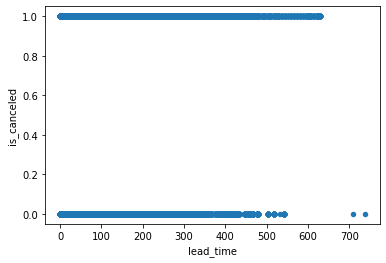

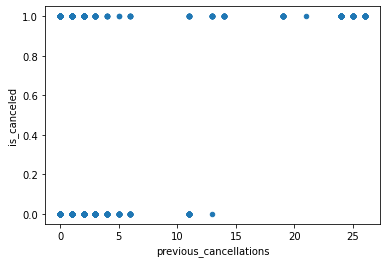

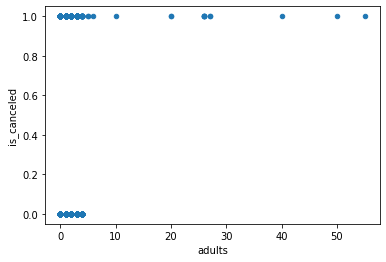

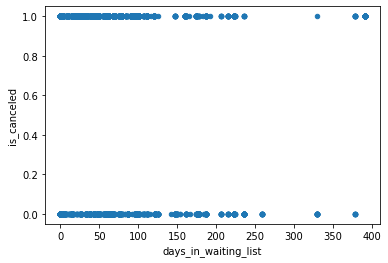

In [24]:
for f in top_cancelation_corrs:
    bookings[[f, 'is_canceled']].plot.scatter(x = f, y = 'is_canceled')

#### Limpieza del Dataset

Para limpiar el dataset debemos analizar como asignar valores a los casos en los que se encuentran datos nulos.

In [25]:
nan_features[nan_features > 0]

children         4
country        488
agent        16340
company     112593
dtype: int64

In [26]:
# Asumimos que la gente que no completa este campo no tiene hijos. 
bookings['children'].replace(np.nan, 0, inplace = True)

# Reemplazamos cada valor por su anterior en el dataframe.
bookings['country'].replace(method='ffill', inplace = True)

# Reemplazo este valor por un ID de una agencia inexistente. La misma representa las reservas 
# pedidas sin agencia.
bookings['agent'].replace(np.nan, bookings['agent'].max() + 1, inplace = True)

# Ídem el punto de arriba.
bookings['company'].replace(np.nan,  bookings['company'].max() + 1, inplace = True)
bookings

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,536.0,544.0,0,Transient,0.00,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,536.0,544.0,0,Transient,0.00,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,536.0,544.0,0,Transient,75.00,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,544.0,0,Transient,75.00,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,544.0,0,Transient,98.00,0,1,Check-Out,2015-07-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119385,City Hotel,0,23,2017,August,35,30,2,5,2,...,No Deposit,394.0,544.0,0,Transient,96.14,0,0,Check-Out,2017-09-06
119386,City Hotel,0,102,2017,August,35,31,2,5,3,...,No Deposit,9.0,544.0,0,Transient,225.43,0,2,Check-Out,2017-09-07
119387,City Hotel,0,34,2017,August,35,31,2,5,2,...,No Deposit,9.0,544.0,0,Transient,157.71,0,4,Check-Out,2017-09-07
119388,City Hotel,0,109,2017,August,35,31,2,5,2,...,No Deposit,89.0,544.0,0,Transient,104.40,0,0,Check-Out,2017-09-07


In [27]:
new_nan_features = pd.isnull(bookings).sum()  
new_nan_features

hotel                             0
is_canceled                       0
lead_time                         0
arrival_date_year                 0
arrival_date_month                0
arrival_date_week_number          0
arrival_date_day_of_month         0
stays_in_weekend_nights           0
stays_in_week_nights              0
adults                            0
children                          0
babies                            0
meal                              0
country                           0
market_segment                    0
distribution_channel              0
is_repeated_guest                 0
previous_cancellations            0
previous_bookings_not_canceled    0
reserved_room_type                0
assigned_room_type                0
booking_changes                   0
deposit_type                      0
agent                             0
company                           0
days_in_waiting_list              0
customer_type                     0
adr                         

In [28]:
bookings.fillna(value=0, inplace=True)
new_nan_features = pd.isnull(bookings).sum()  
new_nan_features

hotel                             0
is_canceled                       0
lead_time                         0
arrival_date_year                 0
arrival_date_month                0
arrival_date_week_number          0
arrival_date_day_of_month         0
stays_in_weekend_nights           0
stays_in_week_nights              0
adults                            0
children                          0
babies                            0
meal                              0
country                           0
market_segment                    0
distribution_channel              0
is_repeated_guest                 0
previous_cancellations            0
previous_bookings_not_canceled    0
reserved_room_type                0
assigned_room_type                0
booking_changes                   0
deposit_type                      0
agent                             0
company                           0
days_in_waiting_list              0
customer_type                     0
adr                         

## Generación y Evaluación de Modelos

### Data Splitting

In [29]:
def compute_values(model, y_test, X_test):
    tn, fp, fn, tp = confusion_matrix(y_test, model.predict(X_test)).ravel()
    precision = tp/(tp + fp)
    recall = tp/(tp + fn)
    print(f"La precision es: {precision}")
    print(f"El recall es: {recall}")
    print(f"El f1-score es: {(2 * recall * precision) / (precision + recall)}")
    print(f"Los mejores hiperparámetros son: {model.best_params_}")
    print(f"El mejor score de entrenamiento es: {model.best_score_}")

In [30]:
training_feature_list = [f for f in list(bookings.columns) if f != 'is_canceled']
X_train, X_test, y_train, y_test = train_test_split(bookings[training_feature_list], 
                                                    bookings['is_canceled'], 
                                                    test_size=0.2, random_state=45)

In [31]:
X_train.shape, y_train.shape

((95512, 31), (95512,))

In [32]:
X_test.shape, y_test.shape

((23878, 31), (23878,))

### Feature Engineering 

Los modelos basados en árboles, necesitan tener features numéricos. Por esto haremos feature engineering en las variables categóricas para así poder entrenar los modelos pedidos.

Primero vamos a transformar las fechas en tres variables numéricas separando el año, mes y día.

In [33]:
bookings = bookings[:-1]

In [34]:
bookings['reservation_status_year'] = bookings['reservation_status_date'].apply(lambda x: int(x.split('-')[0]) if x != 0 else x)
bookings['reservation_status_month'] = bookings['reservation_status_date'].apply(lambda x: int(x.split('-')[1]) if x != 0 else x)
bookings['reservation_status_day'] = bookings['reservation_status_date'].apply(lambda x: int(x.split('-')[2]) if x != 0 else x)
bookings.drop(columns=['reservation_status_date'], inplace = True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

Ahora vamos a transformar el mes en su número de mes correspondiente

In [35]:
bookings['arrival_date_month'] = bookings['arrival_date_month'].apply(month_to_num)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [36]:
bookings.T

,0,1,2,3,4,5,6,7,8,9,...,119379,119380,119381,119382,119383,119384,119385,119386,119387,119388
hotel,Resort Hotel,Resort Hotel,Resort Hotel,Resort Hotel,Resort Hotel,Resort Hotel,Resort Hotel,Resort Hotel,Resort Hotel,Resort Hotel,...,City Hotel,City Hotel,City Hotel,City Hotel,City Hotel,City Hotel,City Hotel,City Hotel,City Hotel,City Hotel
is_canceled,0,0,0,0,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
lead_time,342,737,7,13,14,14,0,9,85,75,...,109,44,188,135,164,21,23,102,34,109
arrival_date_year,2015,2015,2015,2015,2015,2015,2015,2015,2015,2015,...,2017,2017,2017,2017,2017,2017,2017,2017,2017,2017
arrival_date_month,7,7,7,7,7,7,7,7,7,7,...,8,8,8,8,8,8,8,8,8,8
arrival_date_week_number,27,27,27,27,27,27,27,27,27,27,...,35,35,35,35,35,35,35,35,35,35
arrival_date_day_of_month,1,1,1,1,1,1,1,1,1,1,...,31,31,31,30,31,30,30,31,31,31
stays_in_weekend_nights,0,0,0,0,0,0,0,0,0,0,...,1,1,2,2,2,2,2,2,2,2
stays_in_week_nights,0,0,1,1,2,2,2,2,3,3,...,3,3,3,4,4,5,5,5,5,5
adults,2,2,1,1,2,2,2,2,2,2,...,2,2,2,3,2,2,2,3,2,2


Vamos a tomar las columnas con más correlación absoluta

In [37]:
corrs = bookings.corr()['is_canceled']
corrs = corrs[corrs < 1]
abs_corrs = abs(corrs).sort_values()
abs_features_to_train = list(abs_corrs[abs_corrs > 0.02].index)
abs_features_to_train

['stays_in_week_nights',
 'babies',
 'reservation_status_day',
 'adr',
 'days_in_waiting_list',
 'previous_bookings_not_canceled',
 'adults',
 'reservation_status_month',
 'is_repeated_guest',
 'company',
 'previous_cancellations',
 'reservation_status_year',
 'agent',
 'booking_changes',
 'required_car_parking_spaces',
 'total_of_special_requests',
 'lead_time']

Y con mas correlación positiva

In [38]:
corrs = bookings.corr()['is_canceled']
best_corrs = corrs[(corrs < 1) & (corrs > 0)]
top_features_to_train = list(best_corrs.index)
top_features_to_train

['lead_time',
 'arrival_date_year',
 'arrival_date_month',
 'arrival_date_week_number',
 'stays_in_week_nights',
 'adults',
 'children',
 'previous_cancellations',
 'company',
 'days_in_waiting_list',
 'adr']

Ahora le pasamos OneHotEncoder a todos los features no numéricos, que en este caso resultan ser todos categóricos.

In [39]:
abs_to_train = pd.get_dummies(bookings[abs_features_to_train + ['is_canceled']])
abs_to_train.T

,0,1,2,3,4,5,6,7,8,9,...,119379,119380,119381,119382,119383,119384,119385,119386,119387,119388
stays_in_week_nights,0.0,0.0,1.0,1.0,2.0,2.0,2.0,2.0,3.0,3.0,...,3.0,3.00,3.0,4.0,4.0,5.00,5.00,5.00,5.00,5.0
babies,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0
reservation_status_day,1.0,1.0,2.0,2.0,3.0,3.0,3.0,3.0,6.0,22.0,...,4.0,4.00,5.0,5.0,6.0,6.00,6.00,7.00,7.00,7.0
adr,0.0,0.0,75.0,75.0,98.0,98.0,107.0,103.0,82.0,105.5,...,155.0,140.75,99.0,209.0,87.6,96.14,96.14,225.43,157.71,104.4
days_in_waiting_list,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0
previous_bookings_not_canceled,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0
adults,2.0,2.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,...,2.0,2.00,2.0,3.0,2.0,2.00,2.00,3.00,2.00,2.0
reservation_status_month,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,5.0,4.0,...,9.0,9.00,9.0,9.0,9.0,9.00,9.00,9.00,9.00,9.0
is_repeated_guest,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0
company,544.0,544.0,544.0,544.0,544.0,544.0,544.0,544.0,544.0,544.0,...,544.0,544.00,544.0,544.0,544.0,544.00,544.00,544.00,544.00,544.0


In [40]:
top_to_train = pd.get_dummies(bookings[top_features_to_train + ['is_canceled']])
top_to_train.T

,0,1,2,3,4,5,6,7,8,9,...,119379,119380,119381,119382,119383,119384,119385,119386,119387,119388
lead_time,342.0,737.0,7.0,13.0,14.0,14.0,0.0,9.0,85.0,75.0,...,109.0,44.00,188.0,135.0,164.0,21.00,23.00,102.00,34.00,109.0
arrival_date_year,2015.0,2015.0,2015.0,2015.0,2015.0,2015.0,2015.0,2015.0,2015.0,2015.0,...,2017.0,2017.00,2017.0,2017.0,2017.0,2017.00,2017.00,2017.00,2017.00,2017.0
arrival_date_month,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,...,8.0,8.00,8.0,8.0,8.0,8.00,8.00,8.00,8.00,8.0
arrival_date_week_number,27.0,27.0,27.0,27.0,27.0,27.0,27.0,27.0,27.0,27.0,...,35.0,35.00,35.0,35.0,35.0,35.00,35.00,35.00,35.00,35.0
stays_in_week_nights,0.0,0.0,1.0,1.0,2.0,2.0,2.0,2.0,3.0,3.0,...,3.0,3.00,3.0,4.0,4.0,5.00,5.00,5.00,5.00,5.0
adults,2.0,2.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,...,2.0,2.00,2.0,3.0,2.0,2.00,2.00,3.00,2.00,2.0
children,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0
previous_cancellations,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0
company,544.0,544.0,544.0,544.0,544.0,544.0,544.0,544.0,544.0,544.0,...,544.0,544.00,544.0,544.0,544.0,544.00,544.00,544.00,544.00,544.0
days_in_waiting_list,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0


### Árbol de Decisión

#### Entrenamiento

Primero intentamos con los valores absolutos:

In [129]:
tree_params = {'max_features': [8,10,12,15,17], 'criterion':['gini'], 'max_depth':[15,20,25,30,40]}
training_feature_list = [f for f in list(abs_to_train.columns) if f != 'is_canceled']
X_train, X_test, y_train, y_test = train_test_split(abs_to_train[training_feature_list], 
                                                    abs_to_train['is_canceled'], 
                                                    test_size=0.2, random_state=2)

abs_dtc = GridSearchCV(DecisionTreeClassifier(random_state=2), tree_params, cv=KFold(n_splits=10, shuffle=True, random_state=2), refit=True, n_jobs=-1)
abs_dtc.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=10, random_state=2, shuffle=True),
             estimator=DecisionTreeClassifier(random_state=2), n_jobs=-1,
             param_grid={'criterion': ['gini'],
                         'max_depth': [15, 20, 25, 30, 40],
                         'max_features': [8, 10, 12, 15, 17]})

In [130]:
compute_values(model = abs_dtc, y_test=y_test, X_test=X_test)

La precision es: 0.8145886148882231
El recall es: 0.819404196128434
El f1-score es: 0.8169893094481364
Los mejores hiperparámetros son: {'criterion': 'gini', 'max_depth': 30, 'max_features': 12}
El mejor score de entrenamiento es: 0.8659211746005356


Y ahora con los valores directamente más correlacionados

In [126]:
tree_params = {'max_features': [4,6,8,10], 'criterion':['gini'], 'max_depth':[15,20,25,30,40]}
training_feature_list = [f for f in list(top_to_train.columns) if f != 'is_canceled']
X_train, X_test, y_train, y_test = train_test_split(top_to_train[training_feature_list], 
                                                    top_to_train['is_canceled'], 
                                                    test_size=0.2, random_state=2)

top_dtc = GridSearchCV(DecisionTreeClassifier(random_state=2), tree_params, cv=KFold(n_splits=10, shuffle=True, random_state=2), refit=True, n_jobs=-1)
top_dtc.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=10, random_state=2, shuffle=True),
             estimator=DecisionTreeClassifier(random_state=2), n_jobs=-1,
             param_grid={'criterion': ['gini'],
                         'max_depth': [15, 20, 25, 30, 40],
                         'max_features': [4, 6, 8, 10]})

In [127]:
compute_values(model = top_dtc, y_test=y_test, X_test=X_test)

La precision es: 0.6962259782357028
El recall es: 0.697113712762258
El f1-score es: 0.6966695626991022
Los mejores hiperparámetros son: {'criterion': 'gini', 'max_depth': 40, 'max_features': 4}
El mejor score de entrenamiento es: 0.7761305173478463


Utilizamos 10 folds y la métrica $f1$ para comparar los modelos. El primer árbol resulta ser bastante mejor que el segundo para los valores utilizados según la búsqueda realizada.

#### Gráfico del Modelo

Plottearemos únicamente las primeras dos capas del árbol, pues este es muy profundo y no se puede visualizar correctamente.

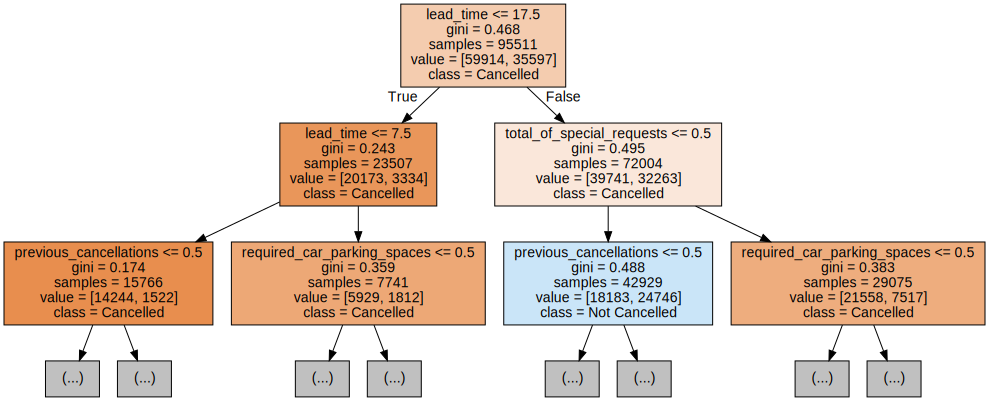

<Figure size 1800x1440 with 0 Axes>

In [122]:
fig = plt.figure(figsize=(25,20))

X_train, X_test, y_train, y_test = train_test_split(abs_to_train[[f for f in list(abs_to_train.columns) if f != 'is_canceled']], 
                                                    abs_to_train['is_canceled'], 
                                                    test_size=0.2, random_state=2)

dot_data = tree.export_graphviz(abs_dtc.best_estimator_, out_file=None, 
                                feature_names=X_train.columns,  
                                class_names=['Cancelled', 'Not Cancelled'],
                                filled=True, 
                                max_depth=2)

graph = graphviz.Source(dot_data, format="png") 
graph

Las decisiones que toma el árbol son bastante fáciles de seguir. Primero se pregunta si $\text lead\_time \leq 17.5$, de ser esto verdadero analiza contra el nodo que tiene a la izquierda y de lo contrario a la derecha. Supongamos el caso en el que tenemos un $\text lead\_time = 200$, el modelo en la segunda capa de decisiones se preguntará si la cantidad total de pedidos es menor a $0.5$ y una vez más, de ser falso verificará con el hijo derecho y de ser verdadera la condición validará contra el hijo izquierdo. Esto ocurre a través de todas las capas del árbol hasta que se llega a un nodo hoja, el cuál representa la predicción realizada por el modelo.

#### Performance Review

Se pueden evaluar las métricas con la siguiente llamada:

In [131]:
compute_values(model = abs_dtc, y_test=y_test, X_test=X_test)

La precision es: 0.8145886148882231
El recall es: 0.819404196128434
El f1-score es: 0.8169893094481364
Los mejores hiperparámetros son: {'criterion': 'gini', 'max_depth': 30, 'max_features': 12}
El mejor score de entrenamiento es: 0.8659211746005356


In [139]:
f1_score(y_train, abs_dtc.predict(X_train), average='binary')

0.998158431152035

Y vemos como las predicciones sobre el set de entrenamiento, es lógicamente más alta que las predicciones sobre el set de testing, pues el modelo no pudo entrenarse sobre este último y solo puede hacer predicciones en función de lo aprendido con el set de training.

Mostramos también la matriz de confusión, donde la mayoría de las predicciones son true negatives y luego true positives. 

In [133]:
confusion_matrix(y_test, abs_dtc.predict(X_test))

array([[13642,  1609],
       [ 1558,  7069]])

### Random Forest

#### Entrenamiento

In [140]:
tree_params = {'max_features': [4,6,8,10], 'criterion':['gini'], 'max_depth':[5,15,25,40]}
training_feature_list = [f for f in list(top_to_train.columns) if f != 'is_canceled']
X_train, X_test, y_train, y_test = train_test_split(top_to_train[training_feature_list], 
                                                    top_to_train['is_canceled'], 
                                                    test_size=0.2, random_state=45)

top_rfc = GridSearchCV(RandomForestClassifier(random_state=3), tree_params, cv=KFold(n_splits=10, shuffle=True, random_state=42), refit=True, n_jobs=-1)
top_rfc.fit(X_train, y_train)

KeyboardInterrupt: ignored

In [ ]:
compute_values(model = top_rfc, y_test=y_test, X_test=X_test)

In [47]:
tree_params = {'max_features': [8,12,15,17], 'criterion':['gini'], 'max_depth':[5,15,25,40]}
training_feature_list = [f for f in list(abs_to_train.columns) if f != 'is_canceled']
X_train, X_test, y_train, y_test = train_test_split(abs_to_train[training_feature_list], 
                                                    abs_to_train['is_canceled'], 
                                                    test_size=0.2, random_state=45)

abs_rfc = GridSearchCV(RandomForestClassifier(random_state=3), tree_params, cv=KFold(n_splits=10, shuffle=True, random_state=42), refit=True, n_jobs=-1)
abs_rfc.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
             estimator=RandomForestClassifier(random_state=3), n_jobs=-1,
             param_grid={'criterion': ['gini'], 'max_depth': [5, 15, 25, 40],
                         'max_features': [8, 12, 15, 17]})

In [48]:
compute_values(model = abs_rfc, y_test=y_test, X_test=X_test)

La precision es: 0.9254241580146872
El recall es: 0.8229929062042562
El f1-score es: 0.8712080576911616
Los mejores hiperparámetros son: {'criterion': 'gini', 'max_depth': 40, 'max_features': 8}
El mejor score de entrenamiento es: 0.9077802886891091


#### Performance Review

El $f1$ score de los modelos de bosques es superior a los presentados en los modelos donde hay un único árbol decidiendo.